# Objective

In this notebook we are showcasing a model that can predict the review given to an anime by the general public.

After that we are going to fine tune the model on a specific user to try and learn its preferences.

In [1]:
import torch as t

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


# Dataset

After preprocessing (done with knime) we now have a csv file containing the data

The result is a dataset that has splits data like so: User, Anime Information, Rating

In [2]:
from pandas import read_csv
from torch.utils.data import Dataset

class AnimeReviewsDataset(Dataset):
    def __init__(self, path) -> None:
        df = read_csv(path)
        self.ratings = df["rating"].to_list()
        self.users = df["user_id"].to_list()
        df = df.drop(columns=["rating", "user_id"])
        # TODO add genre support
        df = df.drop(columns=["Genres"]) # Not handling genres for now

        self.anime_features = df

    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, index):
        user = t.Tensor([self.users[index]])
        anime_features = t.Tensor(self.anime_features.iloc[[index]].to_numpy().tolist())
        rating = t.Tensor([self.ratings[index]])

        return user, anime_features, rating


dataset = AnimeReviewsDataset("/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/preprocessed_anime_reviews.csv")
print(dataset.__getitem__(120))
print(dataset.anime_features.iloc[[120]])
print("Values of type:")
print(dataset.anime_features["Type"].unique())
types = len(dataset.anime_features["Type"].unique())
print(f"types = {types}")

(tensor([1.]), tensor([[6.5900e+00, 2.0000e+00, 2.6000e+01, 4.2000e+01, 5.4470e+03, 2.6450e+03]]), tensor([6.]))
     Score  Type  Episodes  Studios  Ranked  Popularity
120   6.59     2        26       42    5447        2645
Values of type:
[0 1 2 3 4 5]
types = 6


# Separate the dataset

We split the dataset into training, test and validation

In [13]:
from torch.utils.data import random_split, DataLoader
batch_size = 2048

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

# Define a generic step

We perform this step regardless of the model, optimizer, or the phase we are in (training / test)

In [4]:
def run_step(model, loss_fn, features, target):
    features = features.squeeze().to(device)
    target = target.squeeze().long().to(device)
    ones = t.ones(target.shape).long().to(device)
    target = t.sub(target, ones) # To go from ratings in [1:10] to values in [0:9]
    x = model(features)
    loss = loss_fn(x, target)
    return loss, x

# The Model

Now it is time to build the model that predicts the value of a rating given the features

In [5]:
class MLP_Predictor(t.nn.Module):
    def __init__(self, types, emb_size, device, ratings = 10, hidden_size = 4096) -> None:
        super().__init__()
        self.device = device
        self.embed = t.nn.Embedding(types, emb_size).to(device)
        self.sequential = t.nn.Sequential(
            # We expect 5 features + the type
            t.nn.LayerNorm(5 + emb_size),
            t.nn.Linear(emb_size + 5, hidden_size // 4),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 4),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 4, hidden_size // 2),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 2),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 2, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.LayerNorm(hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.BatchNorm1d(hidden_size),
            t.nn.Linear(hidden_size, ratings)
        ).to(device)


    def forward(self, x):
        B, L = x.shape
        x.to(self.device)
        assert L == 6, "This predictor expects a 6-element feature vector"

        # Get the type (position 1 in the feature vector)
        ty = x[:, 1:2].long().squeeze()
        # Remove the type from x
        x = t.cat([x[:, :1], x[:, 2:]], dim=1)
        #Embed the type
        ty = self.embed(ty)

        x = t.cat([x, ty], dim=1)
        x = self.sequential(x)
        return x

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
        return human_format(sum(p.numel() for p in self.parameters()))


model = MLP_Predictor(types, 10, device, 10, 8192)
print(model.size())

310.63M


# First Steps

Here we check if everything is set up correctly

In [6]:
loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
_, features, target = next(iter(train_dataloader))
loss, logits = run_step(model, loss_fn, features, target)
loss

tensor(2.4467, device='cuda:0', grad_fn=<NllLossBackward0>)

# Loading an existing model

It could be useful to start from where we left off.

In [7]:
import os
def get_unique_experiment_name():
    return model.__class__.__name__ + "_" + model.size() 

models_dir = "/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/"
checkpoints = os.listdir(models_dir)
unique_name = get_unique_experiment_name()
checkpoints = [ f for f in checkpoints if f[:min(len(unique_name), len(f))] == unique_name ]
if len(checkpoints) == 0:
    print("Starting from fresh: no models to load")
    epoch = 0
else:
    checkpoints.sort(key=lambda x: int(x[x.index("-") + 1:-3]), reverse=True)

    epoch = int(checkpoints[0][checkpoints[0].index("-") + 1:-3])
    print(f"Loading from {models_dir + checkpoints[0]}")
    model.load_state_dict(t.load(models_dir + checkpoints[0], weights_only=True))
    print(f"Loaded epoch {epoch}")

Loading from /home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/MLP_Predictor_310.63M_epoch-0.pt
Loaded epoch 0


# Training Loop

We set up a simple training loot that uses the validation and training sets to train the model

In [10]:
from tqdm import tqdm
from IPython.display import clear_output

train_losses = []
validation_losses = []

epochs = epoch + 2 # Set this to the number of training epochs you want to perform

with t.no_grad(): # To initialize the eval loss before training
    model.train(False)
    _, fe, ta = next(iter(validation_dataloader))
    loss, _ = run_step(model, loss_fn, fe, ta)
    loss = loss.mean().item()
    best_eval_loss = loss
    model.train(True)

while epoch < epochs:
    current_train_loss = []
    current_eval_loss = []
    for user, features, target in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss, _ = run_step(model, loss_fn, features, target)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        current_train_loss.append(loss.item())

        #Validation Step
        with t.no_grad():
            model.train(False)
            _, fe, ta = next(iter(validation_dataloader))
            loss, _ = run_step(model, loss_fn, fe, ta)
            loss = loss.mean().item()
            validation_losses.append(loss)
            current_eval_loss.append(loss)
            if loss < best_eval_loss: # Getting the best model
                best_eval_loss = loss
                best_model = model
                best_epoch = epoch
            model.train(True)
    
    clear_output()
    print(f"Finished epoch {epoch}")
    print(f"Training loss average = {sum(current_train_loss) / len(current_train_loss)}")
    eval_loss = sum(current_eval_loss) / len(current_eval_loss)
    print(f"Evaluation loss average = {eval_loss}")
    print(f"Current Best Epoch: {best_epoch}: Validation Loss: {best_eval_loss}")
    epoch += 1

print(f"Going back to epoch {best_epoch}: validation loss: {best_eval_loss}")
model = best_model
epoch = best_epoch


Finished epoch 0
Training loss average = 1.7624739006399195
Evaluation loss average = 1.7561628605682296
Current Best Epoch: 0: Validation Loss: 1.7561628605682296
Going back to epoch 0: validation loss: 1.7561628605682296


# Plotting the epoch

Using matplotlib to plot the result of the experiment

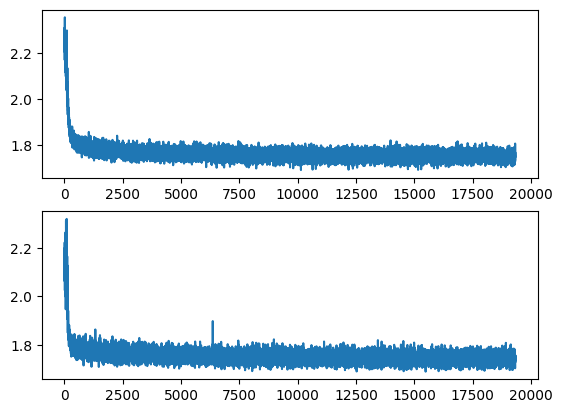

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)

x = list(range(1, len(train_losses) + 1))
axs[0].plot(x, train_losses)


x = list(range(1, len(validation_losses) + 1))
# TODO use the median to remove outliers
axs[1].plot(x, validation_losses)
plt.show()

# Saving the model

As long as we are carrying out the same experiment we should be able to save and load the model.
This saves a lot of time and allows us to restart from where we left off the previous time.

In [12]:
t.save(model.state_dict(), f"/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/{get_unique_experiment_name()}_epoch-{epoch}.pt")

# Testing the model

We are going to calculate some metrics on the test set:

- First, we are going to calculate the loss on the test set
- Secondly, we consider the most likely value of the model to be the predicted value
- Then, we are going to perform a sampling from the tensor and get it as a prediction

In [14]:
from sklearn.metrics import classification_report


test_losses = []
y_true = []
y_pred_map = []
y_pred_sampled = []

with t.no_grad():
    model.train(False)
    for _, features, target in tqdm(test_dataloader):
        loss, logits = run_step(model, loss_fn, features, target)
        loss = loss.item()
        test_losses.append(loss)

        target = target.long().squeeze().tolist()
        y_true = y_true + target

        #Get likeliest value for each element of the batch
        likeliest = t.argmax(logits, dim=1)
        likeliest = likeliest + t.ones(likeliest.shape).to(device) # Going from [0, 9] back to [1 - 10]
        y_pred_map = y_pred_map + likeliest.squeeze().tolist()

        #Get top_k values
        logits = t.nn.functional.softmax(logits, dim=1)
        sampled = t.multinomial(logits, 1)
        sampled = sampled + t.ones(sampled.shape).to(device) # Going from [0, 9] back to [1 - 10]
        sampled = sampled.squeeze().tolist()
        y_pred_sampled = y_pred_sampled + sampled


print(f"Average test loss: {sum(test_losses) / len(test_losses)}")
print(f"-------------------------")
print(f"Maximum A Posteriori Probability")
print(classification_report(y_true, y_pred_map))
print(f"-------------------------")
print(f"Results sampling from the model")
print(classification_report(y_true, y_pred_sampled))


100%|██████████| 2761/2761 [11:22<00:00,  4.05it/s]


Average test loss: 1.7447071554262714
-------------------------
Maximum A Posteriori Probability


/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     29377
           2       0.00      0.00      0.00     37152
           3       0.00      0.00      0.00     65037
           4       0.00      0.00      0.00    138039
           5       0.00      0.00      0.00    328763
           6       0.21      0.04      0.07    663260
           7       0.29      0.47      0.36   1306790
           8       0.31      0.53      0.39   1450497
           9       0.31      0.22      0.26    970642
          10       0.41      0.12      0.18    663902

    accuracy                           0.30   5653459
   macro avg       0.15      0.14      0.13   5653459
weighted avg       0.27      0.30      0.26   5653459

-------------------------
Results sampling from the model
              precision    recall  f1-score   support

           1       0.02      0.02      0.02     29377
           2       0.02      0.01      0.02     37152
           3       0